# 制作VAE的训练集
把到处收集的midi转为numpy矩阵

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np

import sys
sys.path.append("../..")
from utils.midiarray import *

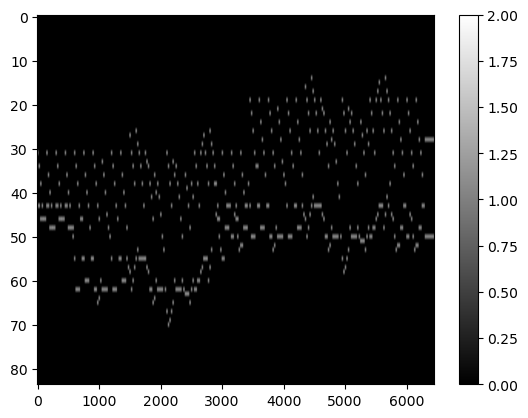

In [2]:
# 示例用法
arr = midi2numpy('../inferMusic/孤独な巡礼simple.mid', track_separate=False, time_step=0.01, time_first=False)
numpy2midi(arr, time_step=0.01, time_first=False).save('test.mid')
plt.imshow(arr, cmap='gray', aspect='auto')
plt.colorbar()
plt.show()

In [2]:
import random

# 递归查找目录下所有的mid文件
def find_midi_files(directory, container = []):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                container.append(os.path.join(root, file))
        for dir in dirs:
            find_midi_files(os.path.join(root, dir), container)
    return container

midi_files = find_midi_files('../sourceMIDI')
random.shuffle(midi_files)
len(midi_files)

2336

In [3]:
# 分析每个mid文件，切片成660帧一组
time_step = 1/22050*384
frame_num = 660
overlap = 10
id = 0
buffer = np.zeros((84, frame_num), dtype=np.int8)
buffer_time = 0

folder_path = 'gen_example'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for file in midi_files:
    _arr = midi2numpy(file, track_separate=False, time_step=time_step, time_first=False)
    total_time = _arr.shape[1]
    time_begin = 0
    time_end = frame_num - buffer_time
    while time_end < total_time:
        buffer[:, buffer_time:frame_num] = _arr[:, time_begin:time_end]
        for note in buffer:
            if note[0] == 1:    # 把没有onset的音符去掉，这是被分段打断的音符的后半部分
                for i in range(len(note)):
                    if note[i] == 1:
                        note[i] = 0
                    else:
                        break
        if buffer.sum() > 2:
            np.save(f'gen_example/{id}.npy', buffer)
        time_begin = max(0, time_end - overlap)
        time_end = time_begin + frame_num
        id += 1
        buffer_time = 0
    buffer_time = total_time - time_begin
    buffer[:, 0:buffer_time] = _arr[:, time_begin:total_time]

print(id)

23554


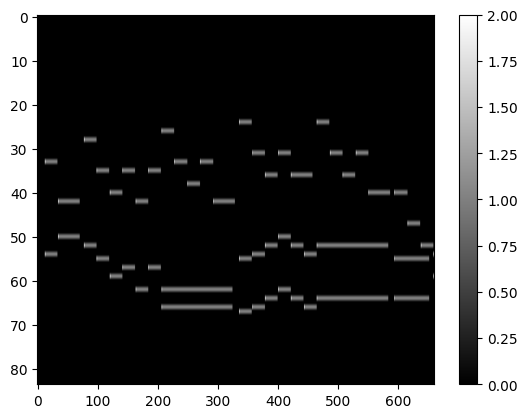

In [ ]:
# 挑一个拿来看看
import random
import matplotlib.pyplot as plt
import numpy as np

choose = random.randint(0, 23554)
arr = np.load(f'gen_example/{choose}.npy')
plt.imshow(arr, cmap='gray', aspect='auto')
plt.colorbar()
plt.show()